In [512]:
import os
import random
import re
import string

import nltk
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andrewmartin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewmartin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andrewmartin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [513]:
df_raw = pd.read_csv("data-coding-list.csv")

In [514]:
df_raw.head()

,study_id,pdf_downloaded,data_coding_status,citation_screening_status,category_manual,citation_title,citation_abstract,citation_authors,citation_journal_name,citation_journal_volume,citation_pub_year,citation_keywords
0,4991658,NaN,NaN,included,algae,Reprint of Comparison of climate signals obtai...,Coralline algae have been used for sclerochron...,"Blicher, M.; Halfar, J.; Hetzinger, S.; Juul-P...",NaN,526,2019.0,Geochemistry & Geophysics; Red coralline algae...
1,4940443,NaN,NaN,included,archeology,The paleolithic of Siberia,NaN,"Anonymous; Gromov, V. I.",NaN,10,1928.0,NaN
2,4941166,NaN,NaN,included,archeology,Concerning the antiquity and origin of reindee...,ACCORDING to existing archaeological data the ...,"Levin, M. G.; Zolotarev, A. M.",NaN,1,1940.0,APEC countries; America; Animal Science (Gener...
3,4941274,NaN,NaN,included,archeology,Archaeology in the U.S.S.R. The forest zones,NaN,"Childe, V. G.",NaN,43,1943.0,NaN
4,4941417,NaN,NaN,included,archeology,Notes on the domestication of the reindeer,NaN,"Mirov, N. T.",NaN,47,1945.0,NaN


## Data preprocessing

In [515]:
def preprocess_text(corpus):
    """Pre-process corpus and generate tokens

    Args:
        corpus: corpus to tokenize.

    Returns:
        Tokenized corpus.
    """

    stemmer = WordNetLemmatizer()

    corpus = str(corpus).lower()  # Lowercase words
    corpus = re.sub(r"\[(.*?)\]", "", corpus)  # Remove [+XYZ chars] in content
    corpus = re.sub(r"\s+", " ", corpus)  # Remove multiple spaces in content
    corpus = re.sub(r"\w+…|…", "", corpus)  # Remove ellipsis (and last word)
    corpus = re.sub(r"(?<=\w)-(?=\w)", " ", corpus)  # Replace dash between words
    corpus = re.sub(f"[{re.escape(string.punctuation)}]", "", corpus)  # Remove punctuation

    tokens = word_tokenize(corpus)  # Get tokens from text
    custom_stopwords = set(stopwords.words("english") + ["high", "arctic", "holocene", "record", "change", "past", "bp", "ka", "new", "top", "journal", "year", "change", "rate", "study", "site", "found", "period", "data", "analysis", "ka", "c", "yr", "time", "result", "using", "two", "sample", "species", "many", "part", "use", "model"])
    tokens = [t for t in tokens if not t in custom_stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [stemmer.lemmatize(t) for t in tokens]
    tokens = [t for t in tokens if not t in custom_stopwords]  # Remove stopwords again (after lemma)
    tokenized_corpus = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokenized_corpus

In [516]:
text_columns = ["citation_title", "citation_abstract", "citation_authors", "citation_journal_name"]

df = df_raw.copy()

df["citation_title"] = df["citation_title"].fillna("")
df["citation_abstract"] = df["citation_abstract"].fillna("")
df["citation_authors"] = df["citation_authors"].fillna("")
df["citation_journal_name"] = df["citation_journal_name"].fillna("")
df["citation_authors"] = df["citation_authors"].map(lambda x: preprocess_text(x))

In [517]:
for col in text_columns:
    df[col] = df[col].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2347 entries, 0 to 2346
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   study_id                   2347 non-null   int64  
 1   pdf_downloaded             14 non-null     object 
 2   data_coding_status         7 non-null      object 
 3   citation_screening_status  2347 non-null   object 
 4   category_manual            857 non-null    object 
 5   citation_title             2347 non-null   object 
 6   citation_abstract          2347 non-null   object 
 7   citation_authors           2347 non-null   object 
 8   citation_journal_name      2347 non-null   object 
 9   citation_journal_volume    2088 non-null   object 
 10  citation_pub_year          2333 non-null   float64
 11  citation_keywords          2159 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 220.2+ KB


In [518]:
# Create article column based on title, description, and content
df["source"] = df[text_columns].apply(lambda x: " | ".join(x), axis=1)
df["source"]

0       Reprint of Comparison of climate signals obtai...
1       The paleolithic of Siberia |  | ['anonymous', ...
2       Concerning the antiquity and origin of reindee...
3       Archaeology in the U.S.S.R. The forest zones |...
4       Notes on the domestication of the reindeer |  ...
                              ...                        
2342    Air-Interface: Œ¥18O Records of Past Meteoric ...
2343    Paleo-Ecology of the Yedoma Ice Complex on Sob...
2344    Impact of Holocene climate change on silicon c...
2345    Recent Warming Fuels Increased Organic Carbon ...
2346    Mixed temperature-moisture signal in Œ¥18 o re...
Name: source, Length: 2347, dtype: object

In [519]:
df["tokenized_source"] = df["source"].map(lambda x: preprocess_text(x))
df["tokenized_source"]

0       [reprint, comparison, climate, signal, obtaine...
1                                  [paleolithic, siberia]
2       [concerning, antiquity, origin, reindeer, bree...
3                       [archaeology, ussr, forest, zone]
4                         [note, domestication, reindeer]
                              ...                        
2342    [air, interface, œ¥18o, meteoric, water, benth...
2343    [paleo, ecology, yedoma, ice, complex, sobo, s...
2344    [impact, climate, silicon, cycling, lake, nort...
2345    [recent, warming, fuel, increased, organic, ca...
2346    [mixed, temperature, moisture, signal, œ¥18, b...
Name: tokenized_source, Length: 2347, dtype: object

In [520]:
# Remove duplicated after preprocessing
_, idx = np.unique(df["tokenized_source"], return_index=True)
df = df.iloc[idx, :]

# Remove empty values
df = df.loc[df.tokenized_source.map(lambda x: len(x) > 0), ["source", "tokenized_source"]]

print(f"Original data: {df_raw.shape}")
print(f"Pre-processed data: {df.shape}")

Original data: (2347, 12)
Pre-processed data: (2346, 2)


In [521]:
df["tokenized_source"]

952     [14c, dating, peat, œ¥18o, œ¥d, ground, ice, n...
241     [14c, measurement, macrofossil, varved, sequen...
1372    [83rd, annual, meeting, german, society, mamma...
304     [aasivissuit, great, summer, camp, archaeologi...
1722    [abrupt, climate, transition, northern, north,...
                              ...                        
776     [zonal, distribution, blow, fly, dipt, calliph...
1560    [zooarchaeological, adk, adak, island, central...
1634    [zooarchaeology, modernity, iceland, paper, fo...
90      [zoogeographical, implication, variation, mito...
1423    [zooplankton, zoobenthos, latitude, water, bod...
Name: tokenized_source, Length: 2346, dtype: object

## looking at vocabulary

In [522]:
from collections import Counter 

In [523]:
docs = df["source"].values
tokenized_docs = df["tokenized_source"].values

vocab = Counter()
for token in tokenized_docs:
    vocab.update(token)

In [524]:
vocab.most_common(50)

[('lake', 2200),
 ('climate', 2092),
 ('tree', 1549),
 ('forest', 1451),
 ('temperature', 1400),
 ('ice', 1306),
 ('vegetation', 1280),
 ('northern', 1224),
 ('pollen', 1214),
 ('sediment', 1144),
 ('present', 1066),
 ('region', 1060),
 ('area', 1032),
 ('late', 1028),
 ('north', 972),
 ('age', 898),
 ('condition', 881),
 ('plant', 820),
 ('early', 766),
 ('climatic', 764),
 ('ring', 761),
 ('growth', 754),
 ('last', 748),
 ('cal', 747),
 ('sea', 726),
 ('based', 722),
 ('reconstruction', 710),
 ('fire', 690),
 ('century', 684),
 ('may', 669),
 ('history', 657),
 ('peat', 652),
 ('long', 641),
 ('glacial', 624),
 ('water', 623),
 ('diatom', 621),
 ('also', 619),
 ('tundra', 607),
 ('population', 604),
 ('summer', 595),
 ('assemblage', 575),
 ('used', 572),
 ('similar', 563),
 ('evidence', 553),
 ('response', 549),
 ('core', 548),
 ('environmental', 547),
 ('show', 545),
 ('level', 544),
 ('island', 543)]

## Vectorization using word embeddings

In [525]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [526]:
model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=42)

In [527]:
model.wv.most_similar("pollen")

[('stoma', 0.9452483057975769),
 ('macrofossil', 0.9156205654144287),
 ('fossil', 0.8879936933517456),
 ('assemblage', 0.8623872995376587),
 ('macrofossils', 0.8612541556358337),
 ('spore', 0.849220871925354),
 ('spectrum', 0.8332359790802002),
 ('diagram', 0.8304968476295471),
 ('charcoal', 0.8222082853317261),
 ('modern', 0.8085377216339111)]

In [528]:
vectorized_docs = vectorize(tokenized_docs, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(2346, 100)

## Finding the optimal number of clusters

In [529]:
def mbkmeans_clusters(X, k, mb=500, print_silhouette_values=False):
    """Generate clusters.

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches. Defaults to 500.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.1685593730696865


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.1701525552160363


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.16538701905825193


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8 The average silhouette_score is : 0.1433639530278038


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 9 The average silhouette_score is : 0.14759529826714268


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.13924833523398253


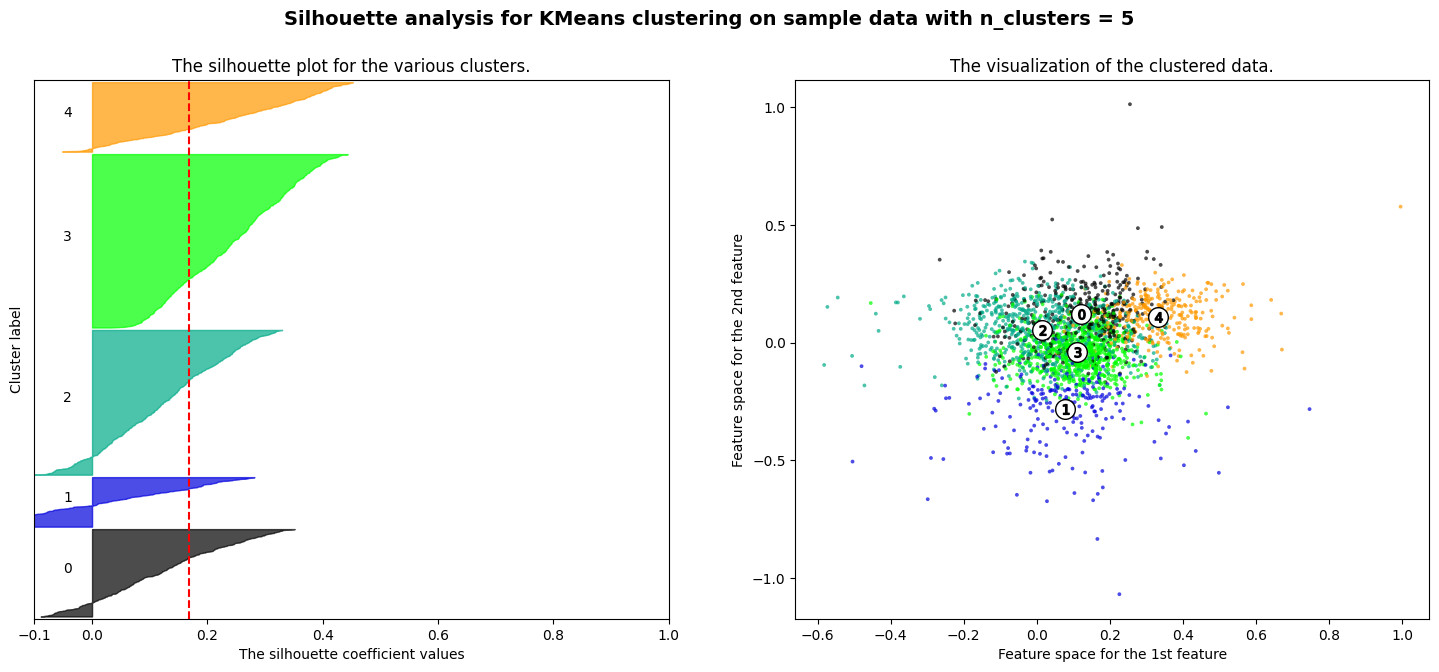

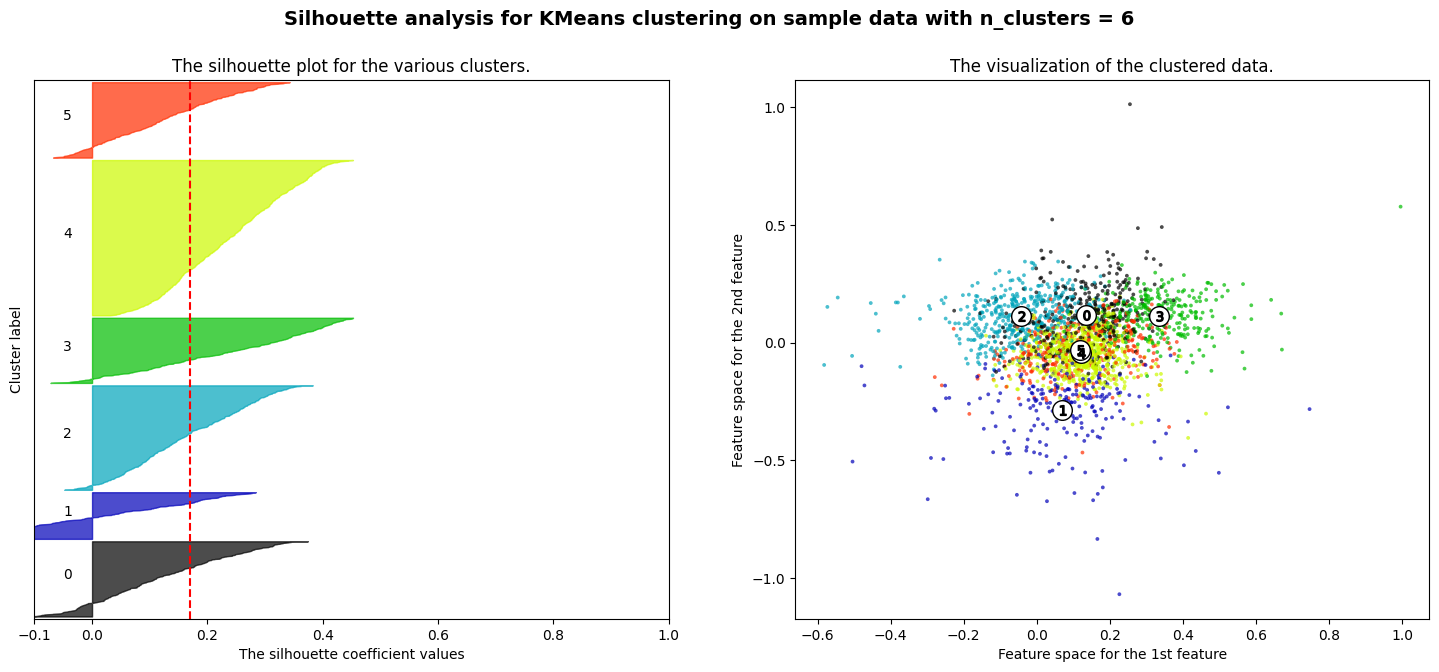

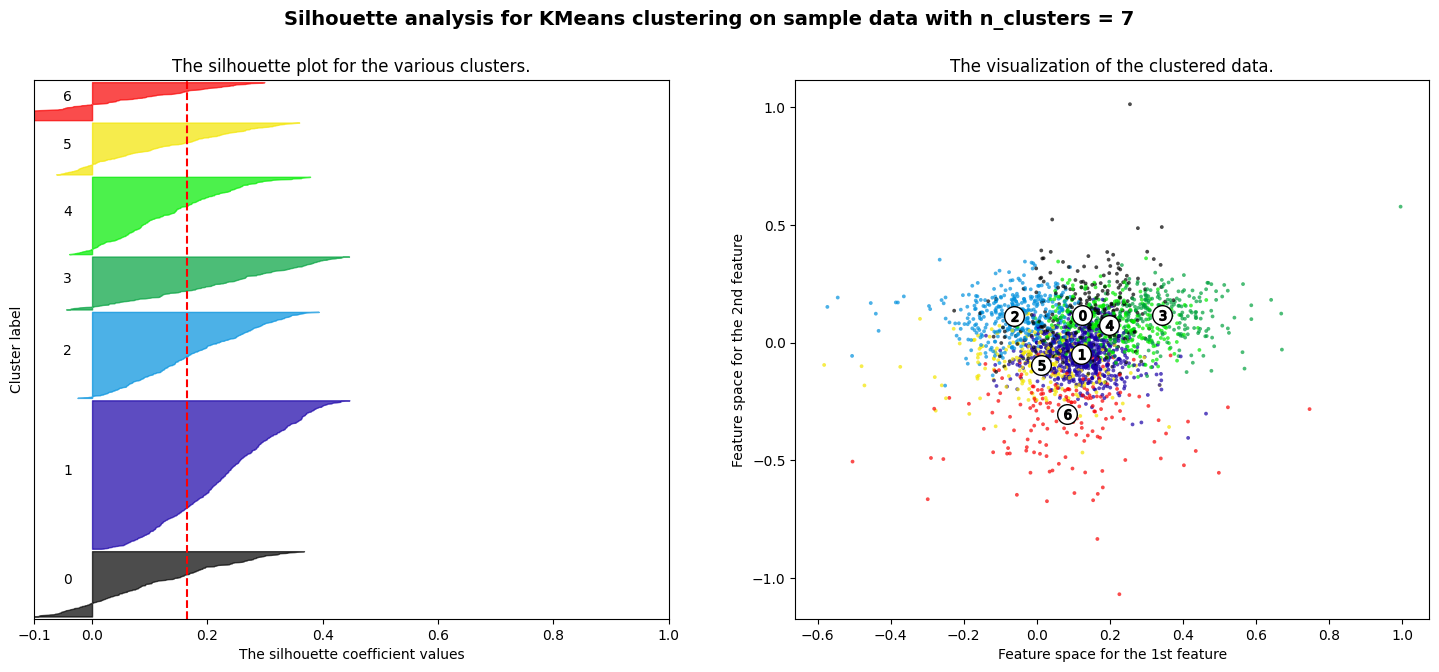

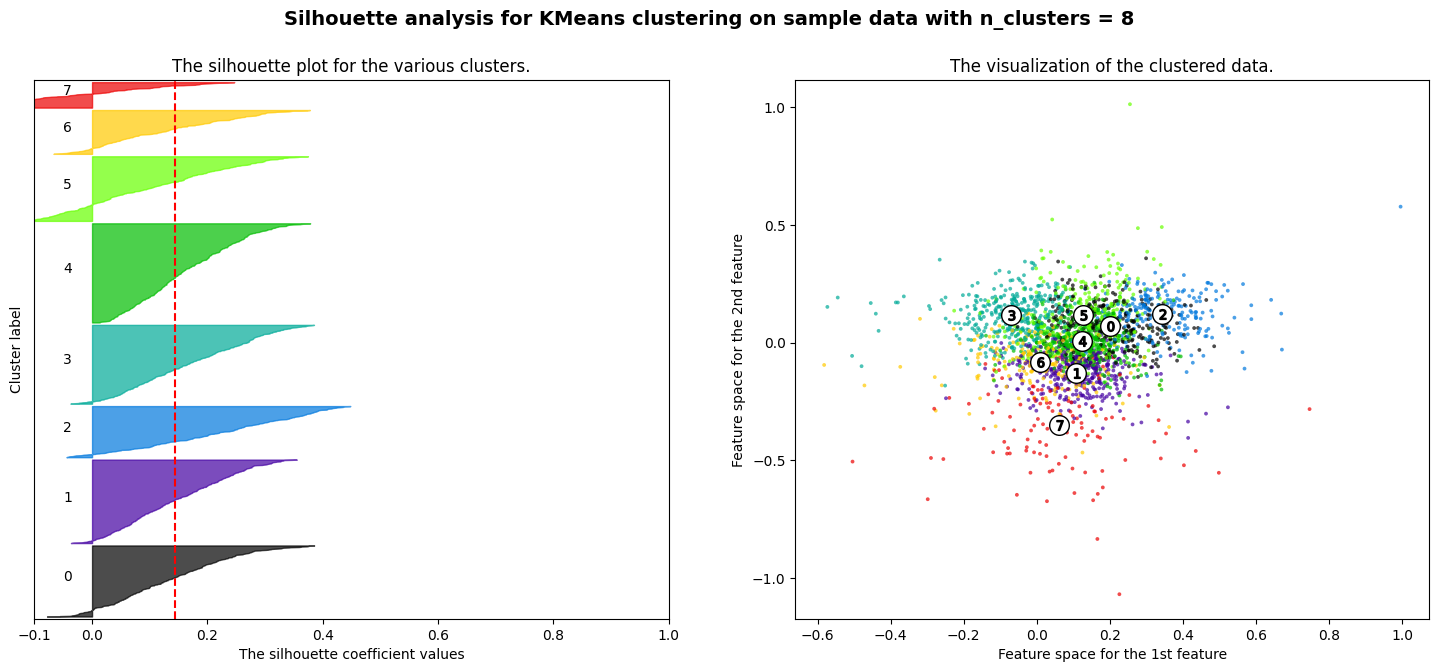

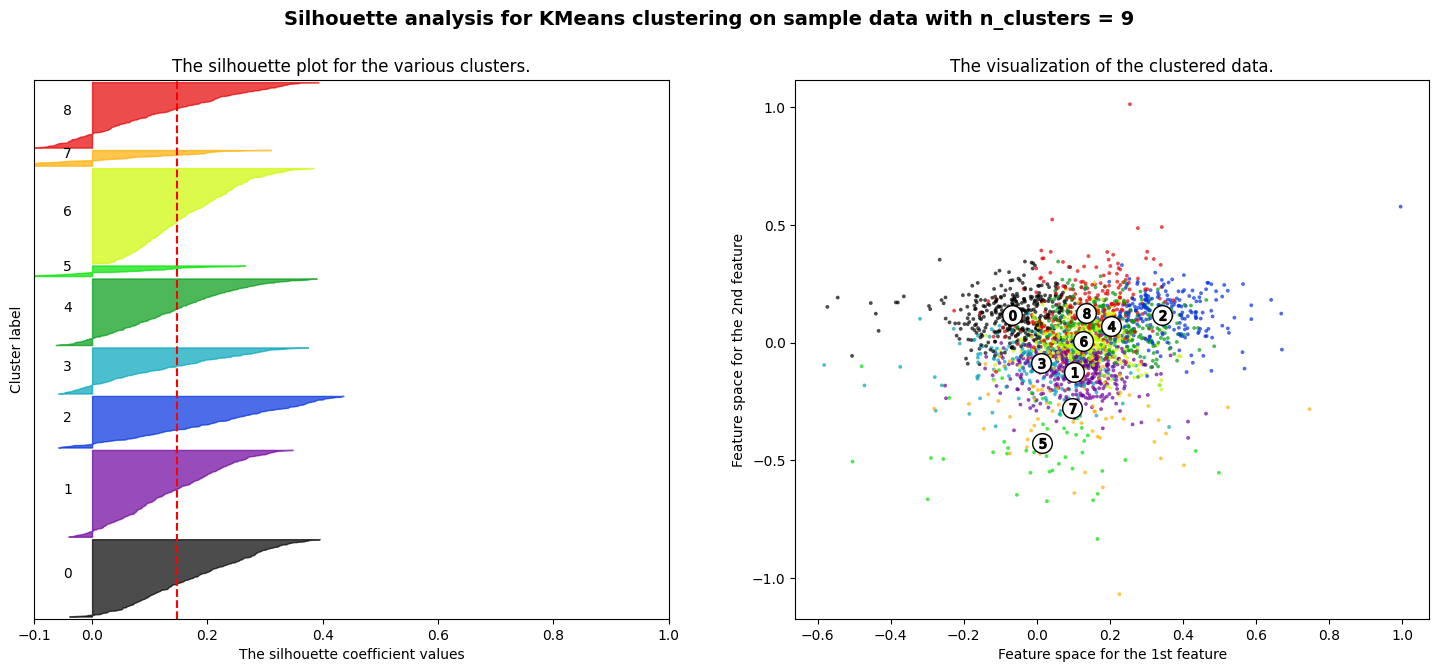

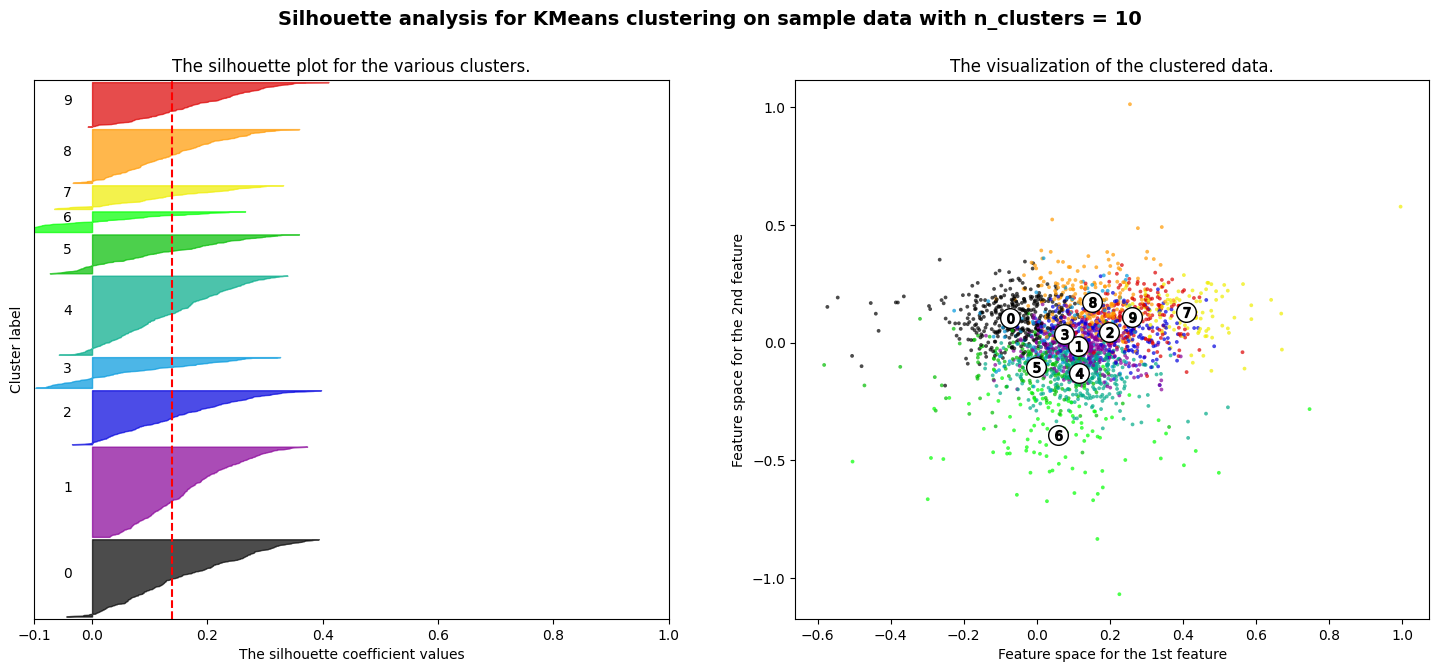

In [530]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X = np.array(vectorized_docs)

range_n_clusters = [5, 6,7,8,9,10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(vectorized_docs)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(vectorized_docs, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(vectorized_docs, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [531]:
clustering, cluster_labels = mbkmeans_clusters(X=vectorized_docs, k=10, print_silhouette_values=True)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10
Silhouette coefficient: 0.15
Inertia:1436.0880065119802
Silhouette values:
    Cluster 1: Size:264 | Avg:0.22 | Min:-0.09 | Max: 0.47
    Cluster 2: Size:503 | Avg:0.19 | Min:-0.01 | Max: 0.41
    Cluster 4: Size:340 | Avg:0.16 | Min:-0.02 | Max: 0.39
    Cluster 3: Size:250 | Avg:0.13 | Min:-0.08 | Max: 0.36
    Cluster 0: Size:306 | Avg:0.12 | Min:-0.07 | Max: 0.36
    Cluster 5: Size:279 | Avg:0.11 | Min:-0.09 | Max: 0.35
    Cluster 8: Size:121 | Avg:0.11 | Min:-0.11 | Max: 0.33
    Cluster 7: Size:193 | Avg:0.08 | Min:-0.10 | Max: 0.30
    Cluster 6: Size:23 | Avg:0.07 | Min:-0.13 | Max: 0.29
    Cluster 9: Size:67 | Avg:0.06 | Min:-0.15 | Max: 0.30


In [532]:
from sklearn.metrics import davies_bouldin_score

In [533]:
#range_n_clusters = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

range_n_clusters = [5, 6, 7, 8, 9, 10]

silhouette_avg = []
Sum_of_squared_distances = []
db = []

In [534]:
for num_clusters in range_n_clusters:
    # initialise kmeans
    km = KMeans(n_clusters=num_clusters).fit(vectorized_docs)
    cluster_labels = km.labels_
    
    # silhouette score
    silhouette_avg.append(silhouette_score(vectorized_docs, cluster_labels))
    
    Sum_of_squared_distances.append(km.inertia_)
        
    db.append(davies_bouldin_score(vectorized_docs,cluster_labels))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

In [535]:
def plot(heading, x_label, y_label, metric):
    plt.plot(range_n_clusters, metric, 'bx-')
    plt.xlabel(x_label) 
    plt.ylabel(y_label) 
    plt.title(heading)
    plt.show()

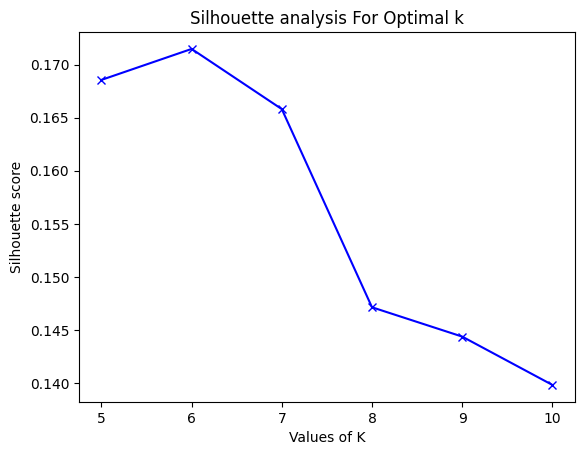

In [536]:
plot('Silhouette analysis For Optimal k', 'Values of K', 'Silhouette score', silhouette_avg)

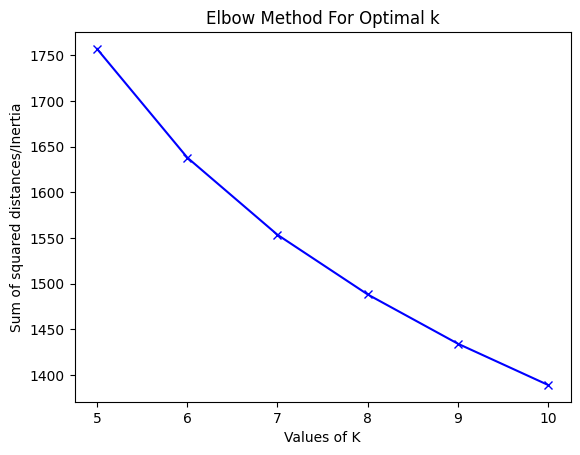

In [537]:
plot('Elbow Method For Optimal k', 'Values of K', 'Sum of squared distances/Inertia', Sum_of_squared_distances)

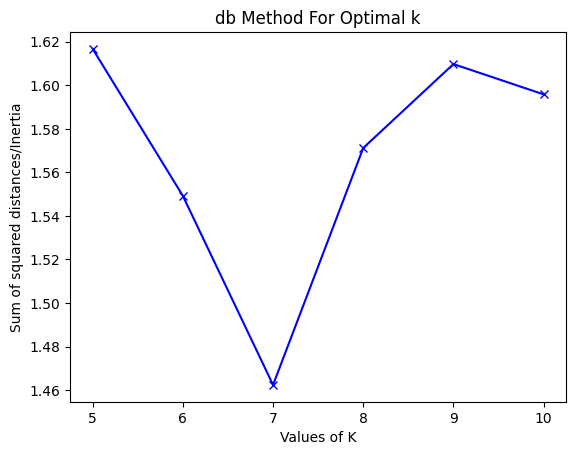

In [538]:
plot('db Method For Optimal k', 'Values of K', 'Sum of squared distances/Inertia', db)

In [539]:
clusters = []
terms_in_clusters = []
for i in range(10):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=40)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Cluster 0: indicates corresponds shoreline coincide rsl rose contrast corresponding span remained oceanographic correspond interpreted begin drop runoff lowered flood desiccation 1900s position reaching drove indicated expanded presumably consecutive lowest continued ce redeposition duration uplift close reveal transgressive generally extremely ela approximately 
Cluster 1: lr height ndvi inter elevational rho standardized fennoscandian trembling adjusted previous residual daily considering signal dendroclimatic exhibited missing depends correlate jja cell earlywood light positively frost nwna corresponded aab explains gain mortality trw gridded parameter divergence dependent meteorological variance index 
Cluster 2: recently lemming center vole reviewed traced norwegian beaver introduction via tradition historic breed note contact phylogeography subspecies sound former genome giant oral gull country inhabitant historically domestication alien generated chapter canis encountered identi

In [540]:
from wordcloud import WordCloud, STOPWORDS

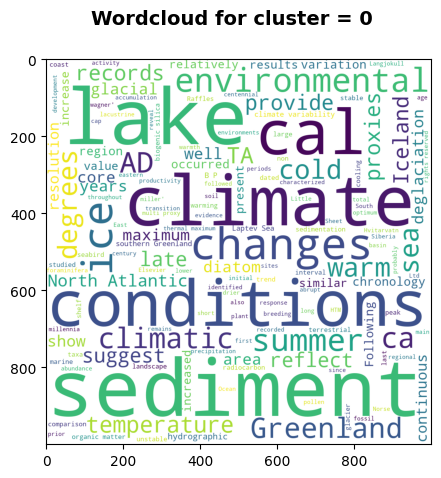

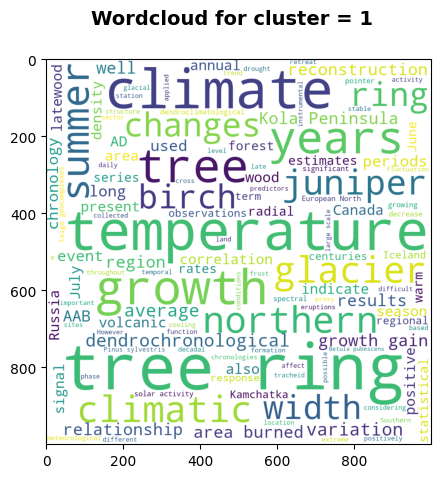

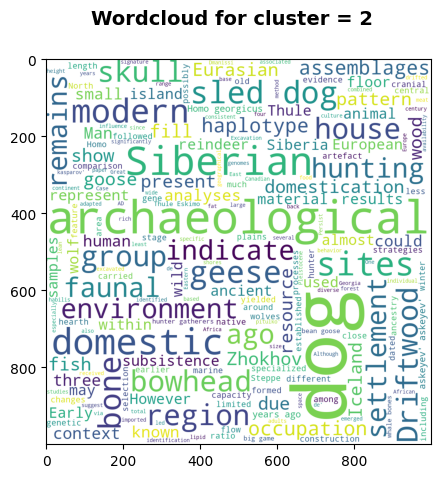

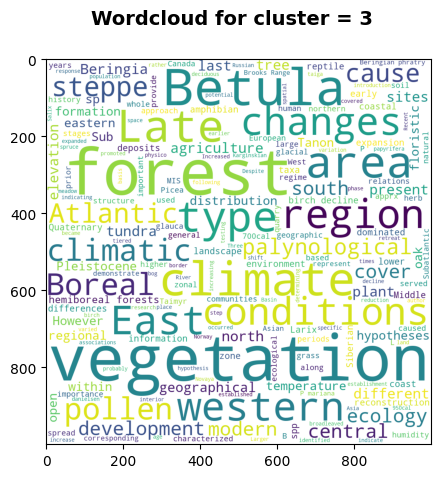

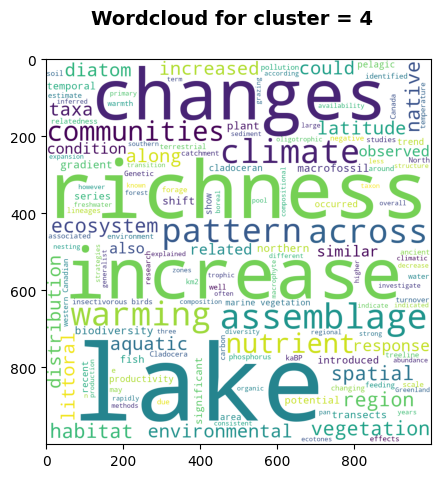

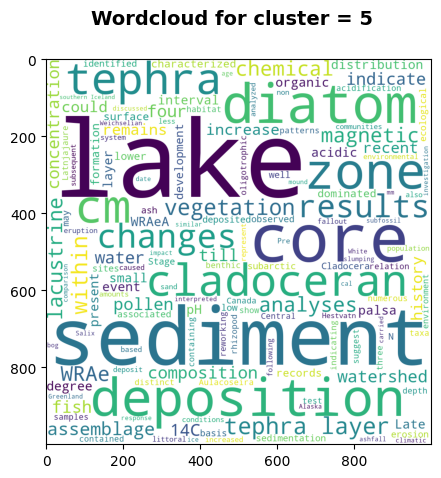

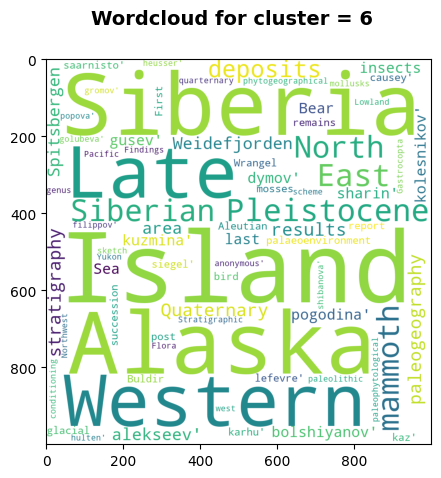

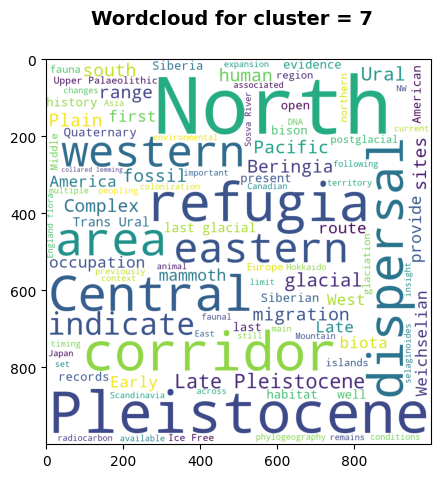

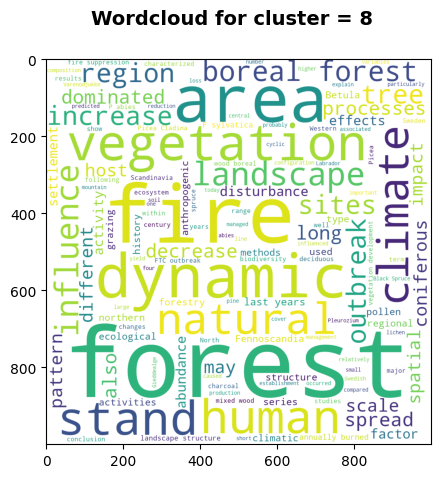

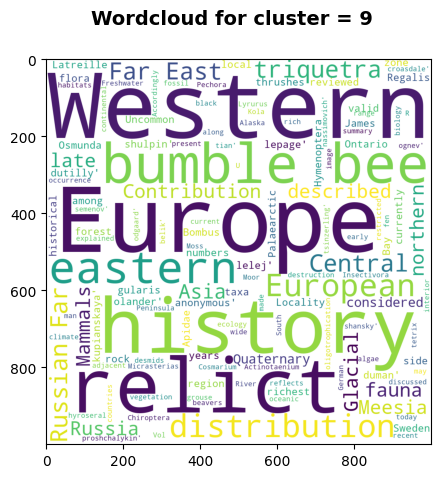

In [541]:
for i  in  range(10) :
    data = []
    test_cluster = i
    most_representative_docs = np.argsort(
        np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
    )
    
    for d in most_representative_docs[:10]:
        data.append(docs[d])

    data = ' '.join(data)
   
    stop_words = stopwords.words("english") + ["high", "model", "arctic", "holocene", "record", "change", "past", "bp", "ka", "new", "top", "journal", "year", "change", "rate", "study", "site", "found", "period", "data", "analysis", "ka", "c", "yr", "time", "result", "using", "two", "sample", "species", "many", "part", "use"]
    wordcloud = WordCloud(width = 1000, height = 1000, 
            stopwords = stop_words,
            background_color ='white', 
            min_font_size = 14).generate(data) 

    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud)
    plt.suptitle(
        "Wordcloud for cluster = %d"
        % i,
        fontsize=14,
        fontweight="bold",
    )
   

In [548]:
test_cluster = 2
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:10]:
    print(docs[d])
    print("-------------")


Ancient DNA reveals the chronology of walrus ivory trade from Norse Greenland | The importance of the Atlantic walrus ivory trade for the colonization, peak, and collapse of the medieval Norse colonies on Greenland has been extensively debated. Nevertheless, no studies have directly traced medieval European ivory back to distinct Arctic populations of walrus. Analysing the entire mitogenomes of 37 archaeological specimens from Europe, Svalbard, and Greenland, we here discover that Atlantic walrus comprises two monophyletic mitochondrial (MT) clades, which diverged between 23 400 and 251 120 years ago. Our improved genomic resolution allows us to reinterpret the geographical distribution of partial MT data from 306 modern and nineteenth-century specimens, finding that one of these clades was exclusively accessible to Greenlanders. With this discovery, we ascertain the biological origin of 23 archaeological specimens from Europe (most dated between 900 and 1400 CE). These results reveal 

In [543]:

df_clusters.to_csv("clustered.csv")


In [544]:
df_clusters["auth"] = df_clusters["text"].apply(lambda x: x.split(" | ")[2])
df_clusters["title"] = df_clusters["text"].apply(lambda x: x.split(" | ")[0])
df_clusters["auth"] = df_clusters["auth"].apply(lambda x: ' '.join(word for word in x.split() if len(word)>3))
df_clusters

,text,tokens,cluster,auth,title
0,14C dating of peat and Œ¥18O-Œ¥D in ground ice...,14c dating peat œ¥18o œ¥d ground ice northwest...,3,"['jungner', 'vasilchuk', 'vasilchuk']",14C dating of peat and Œ¥18O-Œ¥D in ground ice...
1,AMS 14C measurements and macrofossil analyses ...,14c measurement macrofossil varved sequence ne...,5,"['bennike', 'brunnberg', 'demidov', 'possnert'...",AMS 14C measurements and macrofossil analyses ...
2,83rd Annual Meeting of the German-Society-of-M...,83rd annual meeting german society mammalogy d...,2,['anonymous'],83rd Annual Meeting of the German-Society-of-M...
3,Aasivissuit - the great summer camp. Archaeolo...,aasivissuit great summer camp archaeological e...,7,"['gronnow', 'meldgaard', 'nielsen']",Aasivissuit - the great summer camp. Archaeolo...
4,Abrupt Holocene climate transitions in the nor...,abrupt climate transition northern north atlan...,0,"['geirsdottir', 'larsen', 'miller', 'olafsdott...",Abrupt Holocene climate transitions in the nor...
...,...,...,...,...,...
2341,"The zonal distribution of blow-flies (Dipt., C...",zonal distribution blow fly dipt calliphoridae...,2,['nuorteva'],"The zonal distribution of blow-flies (Dipt., C..."
2342,"Zooarchaeological Analysis at ADK-011, Adak Is...",zooarchaeological adk adak island central aleu...,2,"['corbett', 'lefevre', 'west']","Zooarchaeological Analysis at ADK-011, Adak Is..."
2343,Zooarchaeology and Modernity in Iceland | This...,zooarchaeology modernity iceland paper follows...,2,['hambrecht'],Zooarchaeology and Modernity in Iceland
2344,Zoogeographical implications of variation in m...,zoogeographical implication variation mitochon...,2,"['redenbach', 'taylor']",Zoogeographical implications of variation in m...


In [545]:
sub_clusters = []
for name, group in df_clusters.groupby("cluster"):
    group["tokenized_source"] = group[["title", "auth"]].apply(lambda x: " | ".join(x), axis=1)
    model = Word2Vec(sentences=group["tokenized_source"].values, vector_size=100, workers=1, seed=42)
    vectorized_docs = vectorize(group["tokens"].values, model=model)
    len(vectorized_docs), len(vectorized_docs[0])
    
    clustering, cluster_labels = mbkmeans_clusters(X=vectorized_docs, k=5, print_silhouette_values=True)
    y = pd.DataFrame({
        "text": group["text"].values,
        "authors": group["auth"].values,
        # "tokens": [" ".join(text) for text in group],
        "sub_cluster": cluster_labels
    })
    sub_clusters.append(y)

pd.concat(sub_clusters).to_csv("clustered_nest.csv")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5
Silhouette coefficient: 0.32
Inertia:0.04585365854190777
Silhouette values:
    Cluster 0: Size:18 | Avg:0.46 | Min:0.14 | Max: 0.60
    Cluster 1: Size:92 | Avg:0.37 | Min:0.04 | Max: 0.58
    Cluster 4: Size:90 | Avg:0.33 | Min:0.04 | Max: 0.54
    Cluster 2: Size:84 | Avg:0.28 | Min:-0.08 | Max: 0.52
    Cluster 3: Size:22 | Avg:0.17 | Min:-0.15 | Max: 0.42


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5
Silhouette coefficient: 0.31
Inertia:0.19303268068338886
Silhouette values:
    Cluster 0: Size:71 | Avg:0.38 | Min:0.05 | Max: 0.61
    Cluster 2: Size:79 | Avg:0.37 | Min:0.00 | Max: 0.60
    Cluster 4: Size:22 | Avg:0.36 | Min:-0.06 | Max: 0.55
    Cluster 3: Size:82 | Avg:0.23 | Min:-0.28 | Max: 0.51
    Cluster 1: Size:10 | Avg:-0.19 | Min:-0.49 | Max: 0.12


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5
Silhouette coefficient: 0.37
Inertia:0.19058054385442139
Silhouette values:
    Cluster 3: Size:27 | Avg:0.49 | Min:0.09 | Max: 0.61
    Cluster 4: Size:213 | Avg:0.39 | Min:-0.13 | Max: 0.64
    Cluster 0: Size:55 | Avg:0.36 | Min:0.09 | Max: 0.57
    Cluster 1: Size:190 | Avg:0.35 | Min:-0.09 | Max: 0.57
    Cluster 2: Size:18 | Avg:0.25 | Min:-0.14 | Max: 0.48


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5
Silhouette coefficient: 0.34
Inertia:0.015184103216773262
Silhouette values:
    Cluster 2: Size:87 | Avg:0.37 | Min:0.04 | Max: 0.59
    Cluster 0: Size:58 | Avg:0.36 | Min:0.01 | Max: 0.57
    Cluster 1: Size:63 | Avg:0.33 | Min:-0.16 | Max: 0.53
    Cluster 4: Size:19 | Avg:0.31 | Min:-0.08 | Max: 0.51
    Cluster 3: Size:23 | Avg:0.23 | Min:-0.15 | Max: 0.50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5
Silhouette coefficient: 0.38
Inertia:0.04698625211145198
Silhouette values:
    Cluster 0: Size:87 | Avg:0.44 | Min:-0.03 | Max: 0.66
    Cluster 3: Size:125 | Avg:0.39 | Min:-0.17 | Max: 0.64
    Cluster 4: Size:45 | Avg:0.36 | Min:0.00 | Max: 0.57
    Cluster 1: Size:67 | Avg:0.35 | Min:-0.19 | Max: 0.59
    Cluster 2: Size:16 | Avg:0.09 | Min:-0.12 | Max: 0.30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5
Silhouette coefficient: 0.45
Inertia:0.04265671378918798
Silhouette values:
    Cluster 4: Size:80 | Avg:0.49 | Min:-0.02 | Max: 0.70
    Cluster 2: Size:116 | Avg:0.48 | Min:0.05 | Max: 0.70
    Cluster 0: Size:52 | Avg:0.41 | Min:-0.06 | Max: 0.59
    Cluster 3: Size:4 | Avg:0.35 | Min:0.13 | Max: 0.47
    Cluster 1: Size:27 | Avg:0.31 | Min:-0.18 | Max: 0.54
For n_clusters = 5
Silhouette coefficient: 0.43
Inertia:0.004777745509946131
Silhouette values:
    Cluster 3: Size:4 | Avg:0.53 | Min:0.34 | Max: 0.64
    Cluster 1: Size:7 | Avg:0.47 | Min:0.06 | Max: 0.67
    Cluster 4: Size:8 | Avg:0.45 | Min:0.06 | Max: 0.66
    Cluster 0: Size:3 | Avg:0.27 | Min:-0.15 | Max: 0.48
    Cluster 2: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5
Silhouette coefficient: 0.31
Inertia:0.02430015989882471
Silhouette values:
    Cluster 4: Size:71 | Avg:0.40 | Min:0.05 | Max: 0.62
    Cluster 2: Size:13 | Avg:0.33 | Min:-0.05 | Max: 0.55
    Cluster 0: Size:68 | Avg:0.26 | Min:-0.22 | Max: 0.51
    Cluster 1: Size:40 | Avg:0.24 | Min:-0.12 | Max: 0.47
    Cluster 3: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5
Silhouette coefficient: 0.18
Inertia:0.002561037133969742
Silhouette values:
    Cluster 1: Size:51 | Avg:0.25 | Min:-0.00 | Max: 0.43
    Cluster 3: Size:2 | Avg:0.18 | Min:0.02 | Max: 0.35
    Cluster 2: Size:26 | Avg:0.15 | Min:0.03 | Max: 0.29
    Cluster 0: Size:40 | Avg:0.12 | Min:-0.03 | Max: 0.25
    Cluster 4: Size:2 | Avg:0.07 | Min:-0.08 | Max: 0.22
For n_clusters = 5
Silhouette coefficient: 0.36
Inertia:0.007170564818717259
Silhouette values:
    Cluster 4: Size:7 | Avg:0.54 | Min:0.35 | Max: 0.64
    Cluster 2: Size:23 | Avg:0.38 | Min:0.01 | Max: 0.59
    Cluster 0: Size:21 | Avg:0.37 | Min:0.02 | Max: 0.58
    Cluster 1: Size:15 | Avg:0.27 | Min:-0.06 | Max: 0.46
    Cluster 3: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
